# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

Ещё не всё сделано (дерево получается странным, и не реализовано предсказание по построенному дереву)
---

In [428]:
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib

In [429]:
def read_cancer_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    df = df.sample(frac=1).reset_index(drop=True)
    X = df.loc[:, df.columns != 'label']
    y = df.label.astype('category')
    y = df.label.apply(lambda x: 1 if x=='M' else 0)
    return (X,y)

def read_spam_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    df = df.sample(frac=1).reset_index(drop=True)
    df.capital_run_length_average = (df.capital_run_length_average-df.capital_run_length_average.mean())/df.capital_run_length_average.std()
    df.capital_run_length_longest = (df.capital_run_length_longest-df.capital_run_length_longest.mean())/df.capital_run_length_longest.std()
    df.capital_run_length_total = (df.capital_run_length_total-df.capital_run_length_total.mean())/df.capital_run_length_total.std()
    X = df.loc[:, df.columns != 'label']
    y = df.label.astype('category')
    return (X,y)

### Задание 1 (2 балла)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [430]:
from collections import Counter


def classes_probs (x):
    classes = [0,1]
    x_len = len(x)
    p = np.array([(x==cl).sum() / x_len for cl in classes])
    return p

def gini(x):
    p = classes_probs(x)
    return (p*(1-p)).sum()
    
def entropy(x):
    p = classes_probs(x)
    return -(p*np.log(p)).sum()

def gain(left_y, right_y, criterion):

    before_split = np.concatenate([left_y, right_y])
    before_index = len(before_split) * criterion(before_split)
    left_index = len(left_y) * criterion(left_y)
    right_index = len(right_y) * criterion(right_y)

    return before_index - (left_index + right_index)

In [431]:
X = read_cancer_dataset("cancer.csv")
col = X[0].iloc[:,1]

def maxSplitByColumn(X, y, columnName):
    column = X.loc[:, columnName]
    iGains = column.apply(lambda x: (gain(y[column<=x], y[column>x], entropy), x))
    return np.max(iGains)

def getSplitParams(X, y):
    splittedByColumns = X.columns.map(lambda columnName:  (maxSplitByColumn(X, y, columnName), columnName))
    maxSplit = np.max(splittedByColumns)
    splitDimension, splitValue = maxSplit[1], maxSplit[0][1]
    return (splitDimension, splitValue)

def splitByColumn(X, column):
    cols = X.columns
    left_cond = pd.Series(cols).index < columns.get_loc(column)
    x_left =  X[cols[left_cond]]
    right_cond = pd.Series(cols).index >= columns.get_loc(column)
    x_right = X[cols[right_cond]]
    return x_left, x_right

### Задание 2 (2 балла)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [432]:
class DecisionTreeLeaf:
    def __init__(self, y):
        (values,counts) = np.unique(y,return_counts=True)
        ind=np.argmax(counts)
        self.y = y.iloc[ind]

class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right, depth):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right
        self.depth = depth

### Задание 3 (6 баллов)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [433]:
from collections import deque

class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.root = None
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf

    def maxSplitByColumn(self, X, y, columnName):
        column = X.loc[:, columnName]
        iGains = column.apply(lambda x: (gain(y[column<x], y[column>=x], gini), x))
        return np.max(iGains)
        
    def calcSplitParams(self, X, y):
        splittedByColumns = X.columns.map(lambda columnName:  (maxSplitByColumn(X, y, columnName), columnName))
        maxSplit = np.max(splittedByColumns)
        splitDimension, splitValue = maxSplit[1], maxSplit[0][1]
        return (splitDimension, splitValue)

    def splitDataByColumnValue(self, X, y, splitDim, splitVal):
        column = X.loc[:, splitDim]
        left_cond = column < splitVal
        right_cond = column > splitVal
        x_left = X[left_cond]
        x_right = X[right_cond]
        y_left = y[left_cond]
        y_right = y[right_cond]
        return (x_left, y_left, x_right, y_right)

    def buildNodes(self, X, y, depth):
        if((depth>=self.max_depth) or (len(y) < self.min_samples_leaf)):
            return DecisionTreeLeaf(y)
        splitDimension, splitValue = self.calcSplitParams(X, y)
        x_left, y_left, x_right, y_right = self.splitDataByColumnValue(X, y, splitDimension, splitValue)
        n_left = self.buildNodes(x_left, y_left, depth + 1)
        n_right = self.buildNodes(x_right, y_right, depth + 1)
        return DecisionTreeNode(splitDimension, splitValue,  n_left, n_right, depth)

    def fit(self, X, y):
        self.root = self.buildNodes(X, y, 0)
                                        
    def predict_proba(self, X):
        raise NotImplementedError()
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

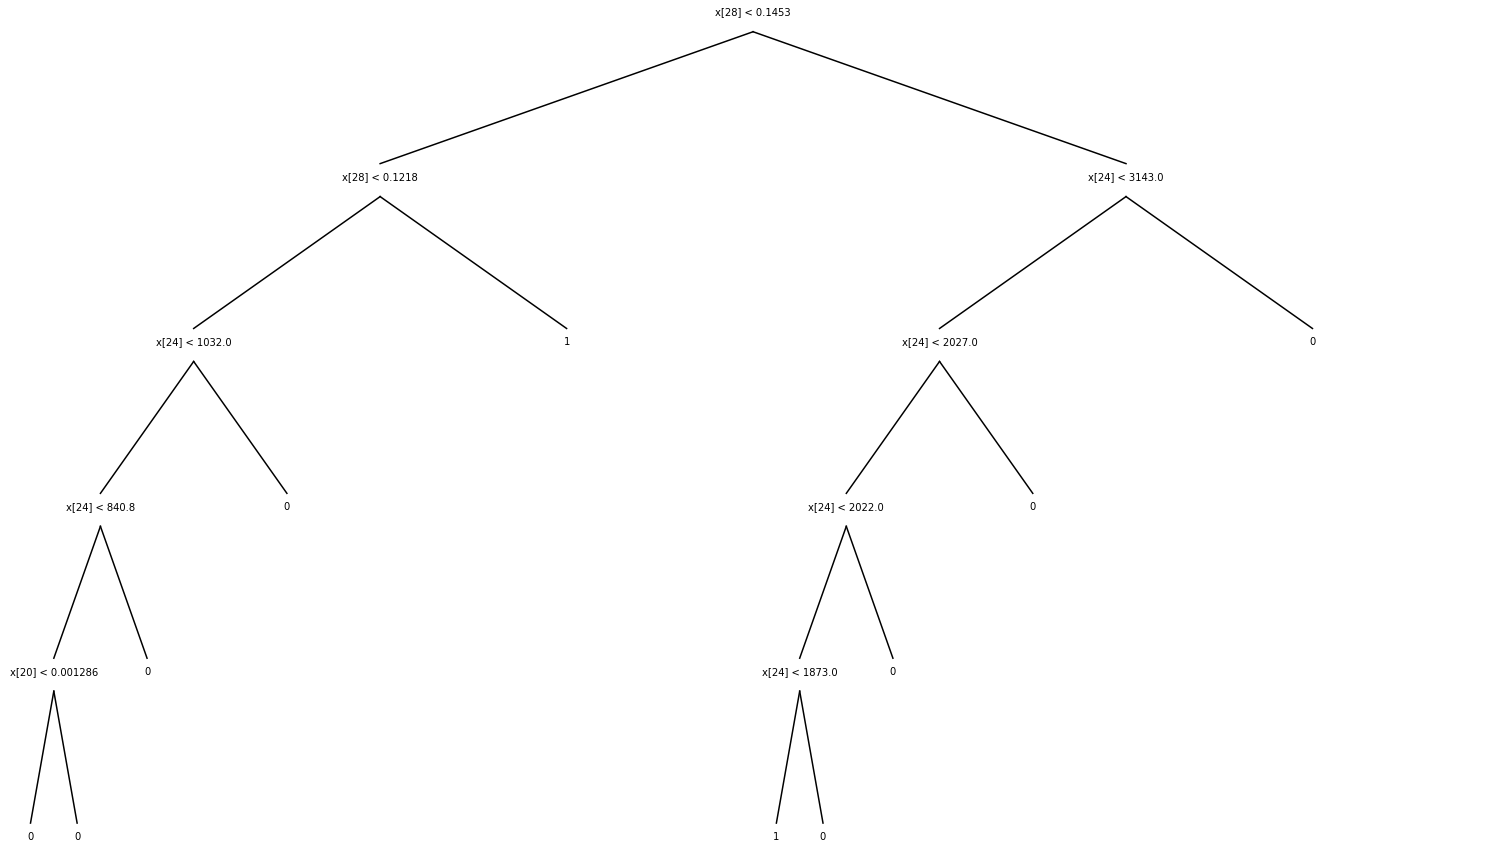

In [427]:
tree = DecisionTreeClassifier(max_depth=5,min_samples_leaf=5)
tree.fit(X[0][0:50], X[1][0:50])
draw_tree(tree)

In [ ]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, f"x[{tree_root.split_dim}] < {tree_root.split_value}",
                horizontalalignment='center')
    elif(isinstance(tree_root, DecisionTreeLeaf)):
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [ ]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

Протестируйте решение на данных cancer и spam.

In [ ]:
X_train, y_train = ...
X_test, y_test = ...
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)